In [1]:
import matplotlib
import matplotlib.pyplot as plt
import json
import random
from scipy.stats import norm

random.seed(42)


json_file = "../simulations/results/QueueAnalysis.json" # sys.argv[1]

f = open(json_file, 'r')
data = json.load(f)

print("data loaded")


import numpy as np

stat_Nq = 'cloudNodeStatW:mean'  #sys.argv[2]
stat_N = 'cloudNodeStatN:timeavg'  #sys.argv[3]
stat_VM = 'cloudNodeStatActiveVM:timeavg'  #sys.argv[4]
#stat = 'cloudNodeStatInterDepartureTime:vector'
# taskTimeStat:vector
# cloudNodeStatInterDepartureTime:vector

stats = [stat_Nq, stat_N, stat_VM]

repetitions_original = {'true':{}, 'false':{}}

for repetition in data:
    for scalar in data[repetition]['scalars']:
        if not scalar['name'] in stats:
            continue
        
        #if data[repetition]['itervars']['distr'] != '1' or data[repetition]['itervars']['fairSharing'] != 'true':
        #    continue
        fairshare = data[repetition]['itervars']['fairSharing']
        N = int(data[repetition]['itervars']['N'])
        #iterations = int(data[repetition]['attributes']['repetition'])
        if not N in repetitions_original[fairshare]:
            repetitions_original[fairshare][N] = {}
        if not scalar['name'] in repetitions_original[fairshare][N]:
            repetitions_original[fairshare][N][scalar['name']] = []
        repetitions_original[fairshare][N][scalar['name']].append(scalar['value'])


print("repetitions loaded")

data loaded
repetitions loaded


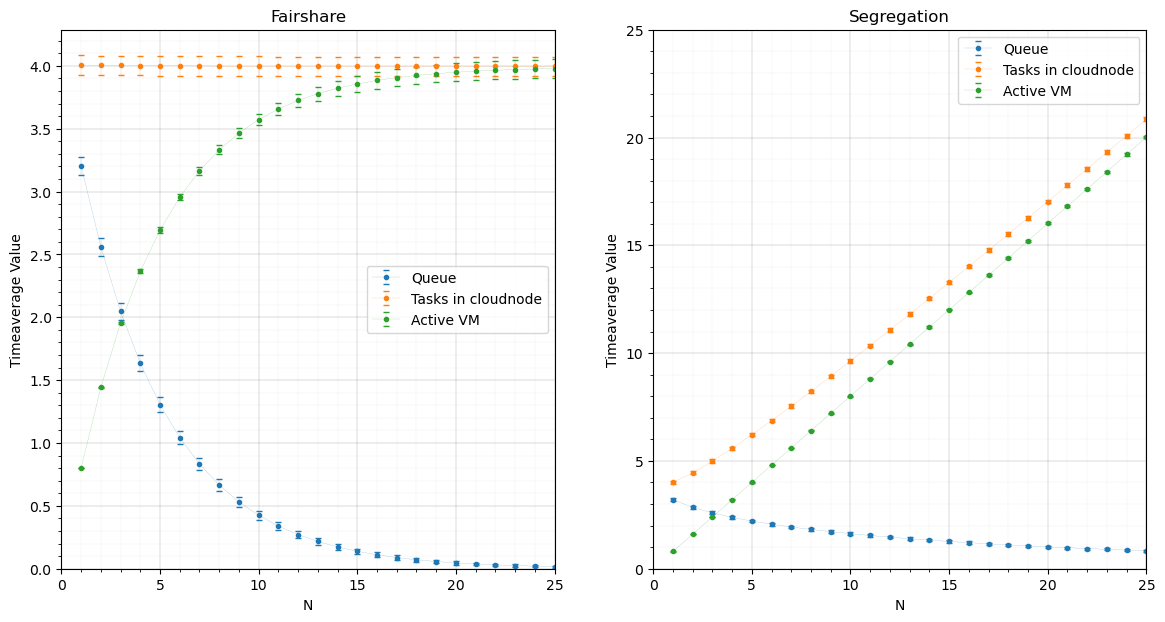

In [88]:
alpha = 0.05
z = norm.ppf(1 - alpha / 2)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs = axs.flatten()

stats = [stat_Nq]
stats = [stat_Nq, stat_N, stat_VM]

labels = {stat_Nq: 'Queue', stat_N: 'Tasks in cloudnode', stat_VM: 'Active VM'}

titles = ['Fairshare', 'Segregation']

means = {'true': {}, 'false': {}}
confidences = {'true': {}, 'false': {}}

for fairshare in repetitions_original:
    for N in repetitions_original[fairshare]:
        means[fairshare][N] = {}
        confidences[fairshare][N] = {}
        for st in stats:
            if st in repetitions_original[fairshare][N]:
                values = repetitions_original[fairshare][N][st]
                if len(values) <= 30:
                    raise ValueError("Not enough samples")
                X = np.mean(values)
                S = np.std(values, ddof=1)
                means[fairshare][N][st] = X
                confidences[fairshare][N][st] = z * S / np.sqrt(len(values))

for i, fairshare in enumerate(means):
    for st in stats:
        N_vals = sorted(means[fairshare].keys())
        avg_vals = [means[fairshare][n][st] for n in N_vals if st in means[fairshare][n]]
        conf_vals = [confidences[fairshare][n][st] for n in N_vals if st in confidences[fairshare][n]]
        axs[i].errorbar(N_vals, avg_vals, yerr=conf_vals, label=labels[st], fmt='-o', markersize=3, linewidth=0.1, capsize=2.5, capthick=1) # capsize=2.5 / 1.5, linewidth=0.1 / 0.2
    axs[i].set_title(f'{titles[i]}')
    axs[i].set_xlabel('N')
    axs[i].set_ylabel('Timeaverage Value')
    axs[i].legend()
    axs[i].minorticks_on()
    axs[i].grid(True, which='major', linestyle='-', linewidth='0.2', color='gray')
    axs[i].grid(True, which='minor', linestyle=':', linewidth='0.1', color='gray')
    axs[i].set_xlim(left=0, right=25)
    axs[i].set_ylim(bottom=0)

axs[1].set_ylim([0, 25])

plt.savefig('QueueAnalysis_full_comparison.pdf', format='pdf')
plt.show()

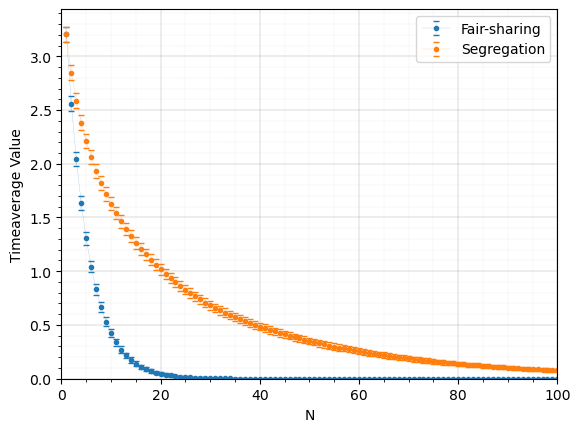

In [10]:
alpha = 0.05
z = norm.ppf(1 - alpha / 2)

stats = [stat_Nq]

labels = {stat_Nq: 'Queue', stat_N: 'Tasks in cloudnode', stat_VM: 'Active VM'}

titles = ['Fair-sharing', 'Segregation']

means = {'true': {}, 'false': {}}
confidences = {'true': {}, 'false': {}}

for fairshare in repetitions_original:
    for N in repetitions_original[fairshare]:
        means[fairshare][N] = {}
        confidences[fairshare][N] = {}
        for st in stats:
            if st in repetitions_original[fairshare][N]:
                values = repetitions_original[fairshare][N][st]
                if len(values) <= 30:
                    raise ValueError("Not enough samples")
                X = np.mean(values)
                S = np.std(values, ddof=1)
                means[fairshare][N][st] = X
                confidences[fairshare][N][st] = z * S / np.sqrt(len(values))
i = 1
for fairshare in means:
    for st in stats:
        N_vals = sorted(means[fairshare].keys())
        avg_vals = [means[fairshare][n][st] for n in N_vals if st in means[fairshare][n]]
        conf_vals = [confidences[fairshare][n][st] for n in N_vals if st in confidences[fairshare][n]]
        plt.errorbar(N_vals, avg_vals, yerr=conf_vals, label=titles[0 if fairshare == "true" else 1], fmt='-o', markersize=3, linewidth=0.1, capsize=2.5, capthick=1) # capsize=2.5 / 1.5, linewidth=0.1 / 0.2
    #plt.set_title(f'{titles[i]}')
    plt.xlabel('N')
    plt.ylabel('Timeaverage Value')
    plt.legend()
    plt.minorticks_on()
    plt.grid(True, which='major', linestyle='-', linewidth='0.2', color='gray')
    plt.grid(True, which='minor', linestyle=':', linewidth='0.1', color='gray')
    plt.xlim(left=0, right=100)
    plt.ylim(bottom=0)

#plt.ylim([0, 25])

plt.savefig('QueueAnalysis_queue_comparison.pdf', format='pdf')
plt.show()

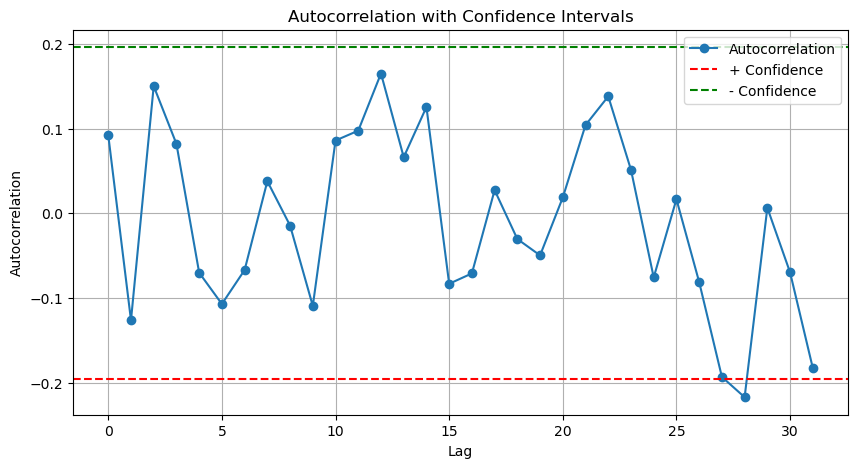

In [90]:
# check autocorrelation just to be sure (even if with different seed they are incorrelated)

samples = repetitions_original['true'][10][stat_Nq]
autocorrelation = []

X_avg = sum(samples) / len(samples)
S2 = sum([(x - X_avg) ** 2 for x in samples]) / (len(samples) - 1)

for i in range(1, min(100, len(samples)//3)):
    sum_ = 0
    for j in range(len(samples) - i):
        sum_ += (samples[j] - X_avg) * (samples[j + i] - X_avg)
    autocorrelation.append(sum_ / ((len(samples) - i) * S2))


# confidence
alpha = 0.05
# get z_alpha/2 value for 95% confidence on a gaussian distribution, based on alpha
z = norm.ppf(alpha / 2)

conf_sampl = z / (len(samples) ** 0.5)

plt.figure(figsize=(10, 5))
plt.plot(autocorrelation, label='Autocorrelation', marker='o')
plt.axhline(y=conf_sampl, color='r', linestyle='--', label='+ Confidence')
plt.axhline(y=-conf_sampl, color='g', linestyle='--', label='- Confidence')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()